In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('question2.csv')
df

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,Salary_50K
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,40,United-States,no
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,13,United-States,no
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,United-States,no
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40,United-States,no
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40,Cuba,no
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,38,United-States,no
32557,40,Private,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,40,United-States,yes
32558,58,Private,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,40,United-States,no
32559,22,Private,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,20,United-States,no


In [3]:
df.info() #Will show the null values
df.dropna(inplace=True,how="all") # Getting rid of empty cells
df.reset_index(inplace=True,drop=True) #Resetting index

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   education       32561 non-null  object
 3   education-num   32561 non-null  int64 
 4   marital-status  32561 non-null  object
 5   occupation      32561 non-null  object
 6   relationship    32561 non-null  object
 7   race            32561 non-null  object
 8   sex             32561 non-null  object
 9   hours-per-week  32561 non-null  int64 
 10  native-country  32561 non-null  object
 11  Salary_50K      32561 non-null  object
dtypes: int64(3), object(9)
memory usage: 3.0+ MB


In [4]:
# Identify categorical features
categorical_columns = df.select_dtypes('object').columns

# Create dummy variables and concatenate with the original DataFrame
df = pd.concat([df, pd.get_dummies(df[categorical_columns], prefix=categorical_columns, drop_first=True)], axis=1)

# Drop the original categorical columns
df = df.drop(categorical_columns, axis=1)
df

,age,education-num,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,...,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,Salary_50K_yes
0,39,13,40,False,False,False,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
1,50,13,13,False,False,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
2,38,9,40,False,False,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,53,7,40,False,False,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,28,13,40,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,12,38,False,False,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
32557,40,9,40,False,False,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,True
32558,58,9,40,False,False,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
32559,22,9,20,False,False,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [5]:
# Define the character(s) you want to check for in column names
target_characters = '-'

# Use list comprehension to create a list of columns containing the target character(s)
columns_with_target_characters = [col for col in df.columns if target_characters in col]

# Display the columns with the target character(s)
print("Columns with '{}' in their names:".format(target_characters))
print(columns_with_target_characters)

Columns with '-' in their names:
['education-num', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Never-worked', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_ 1st-4th', 'education_ 5th-6th', 'education_ 7th-8th', 'education_ Assoc-acdm', 'education_ Assoc-voc', 'education_ HS-grad', 'education_ Prof-school', 'education_ Some-college', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ Adm-clerical', 'occupation_ Armed-Forces', 'occupation_ Craft-repair', 'occupation_ Exec-managerial', 'occupation_ Farming-fishing', 'occupation_ Handlers-cleaners', 'occupation_ Machine-op-inspct', 'occupation_ Other-service', 'occupation_ Priv-house-serv', 'occupation_ Prof-specialty', 'occupation_ Protective-serv', 'occupation_ Tech-

In [6]:
import re

# Define the characters to be replaced
characters_to_replace = {')': '_', '(': '_', '-': '_', '&': ' ', ' ': '_'}

# Replace characters with underscores in column names
df.columns = df.columns.to_series().str.translate(str.maketrans(characters_to_replace))

# Replace multiple underscores with a single underscore
df.columns = df.columns.to_series().apply(lambda x: re.sub('_+', '_', x))

# Display the modified column names
print(df.columns)

Index(['age', 'education_num', 'hours_per_week', 'workclass_Federal_gov',
       'workclass_Local_gov', 'workclass_Never_worked', 'workclass_Private',
       'workclass_Self_emp_inc', 'workclass_Self_emp_not_inc',
       'workclass_State_gov', 'workclass_Without_pay', 'education_11th',
       'education_12th', 'education_1st_4th', 'education_5th_6th',
       'education_7th_8th', 'education_9th', 'education_Assoc_acdm',
       'education_Assoc_voc', 'education_Bachelors', 'education_Doctorate',
       'education_HS_grad', 'education_Masters', 'education_Preschool',
       'education_Prof_school', 'education_Some_college',
       'marital_status_Married_AF_spouse', 'marital_status_Married_civ_spouse',
       'marital_status_Married_spouse_absent', 'marital_status_Never_married',
       'marital_status_Separated', 'marital_status_Widowed',
       'occupation_Adm_clerical', 'occupation_Armed_Forces',
       'occupation_Craft_repair', 'occupation_Exec_managerial',
       'occupation_Farming

In [7]:
X = df.drop('Salary_50K_yes', axis=1) #drop the last column (ie., Result)
y = df['Salary_50K_yes'] #Result is the outcome variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [8]:
# Names of the various classification approaches for easy presentation of the results
names = ["Logistic Regression", "K-Nearest Neighbors", "Random Forest", "AdaBoost"]

scores = []  # List variable to hold classification scores (predictive accuracy scores)

classifiers = [
    ('Logistic Regression', LogisticRegression()),
    ('K-Nearest Neighbors', KNeighborsClassifier(n_neighbors=3)),
    ('Random Forest', RandomForestClassifier(n_estimators=10, max_depth=5, max_features=1)),
    ('AdaBoost', AdaBoostClassifier(learning_rate=0.1))
]

# Run classification models using Pipeline
best_model_info = {"Classifier": "", "Scaler": "", "Feature Selector": "", "Accuracy Score": 0}

for name, classifier in classifiers:
    for scaler in [MinMaxScaler(), StandardScaler()]:
        for selector in [SelectFromModel(RandomForestClassifier(n_estimators=10, max_depth=5)),
                         VarianceThreshold(threshold=0.25)]:
            pipeline = Pipeline(steps=[
                ('feature_selection', selector),
                ('scaling', scaler),
                ('classifier', classifier)
            ])
            pipeline.fit(X_train, y_train)
            print(f"{name} with {type(scaler).__name__} and {type(selector).__name__}")
            score = pipeline.score(X_test, y_test)
            scores.append(score)
            print("Model score: %.3f" % score)
            print("\n -----------------------------------------------------------------------------------")

            # Update best model information if the current model has a higher accuracy score
            if score > best_model_info["Accuracy Score"]:
                best_model_info["Classifier"] = name
                best_model_info["Scaler"] = type(scaler).__name__
                best_model_info["Feature Selector"] = type(selector).__name__
                best_model_info["Accuracy Score"] = score

# End of pipeline

# Create a dataframe for prediction scores
scores_df = pd.DataFrame(zip(names * 4, scores), columns=['Classifier', 'Accuracy Score'])
print("\n\nBest Model:")
print(best_model_info)


Logistic Regression with MinMaxScaler and SelectFromModel
Model score: 0.828

 -----------------------------------------------------------------------------------
Logistic Regression with MinMaxScaler and VarianceThreshold
Model score: 0.790

 -----------------------------------------------------------------------------------
Logistic Regression with StandardScaler and SelectFromModel
Model score: 0.829

 -----------------------------------------------------------------------------------
Logistic Regression with StandardScaler and VarianceThreshold
Model score: 0.790

 -----------------------------------------------------------------------------------
K-Nearest Neighbors with MinMaxScaler and SelectFromModel
Model score: 0.807

 -----------------------------------------------------------------------------------
K-Nearest Neighbors with MinMaxScaler and VarianceThreshold
Model score: 0.758

 -----------------------------------------------------------------------------------
K-Nearest Ne

In [9]:
# Sort the DataFrame by the "Accuracy Score" column in descending order
sorted_scores_df = scores_df.sort_values(by='Accuracy Score', ascending=False)

# Print the sorted DataFrame
print(sorted_scores_df)

             Classifier  Accuracy Score
2         Random Forest        0.829014
0   Logistic Regression        0.828154
12  Logistic Regression        0.823732
14        Random Forest        0.823609
10        Random Forest        0.821029
8   Logistic Regression        0.816730
4   Logistic Regression        0.806658
6         Random Forest        0.800884
9   K-Nearest Neighbors        0.800025
11             AdaBoost        0.797814
13  K-Nearest Neighbors        0.794251
15             AdaBoost        0.794251
3              AdaBoost        0.790443
1   K-Nearest Neighbors        0.789952
7              AdaBoost        0.763911
5   K-Nearest Neighbors        0.758138


C:\Users\npear\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.833681365925562


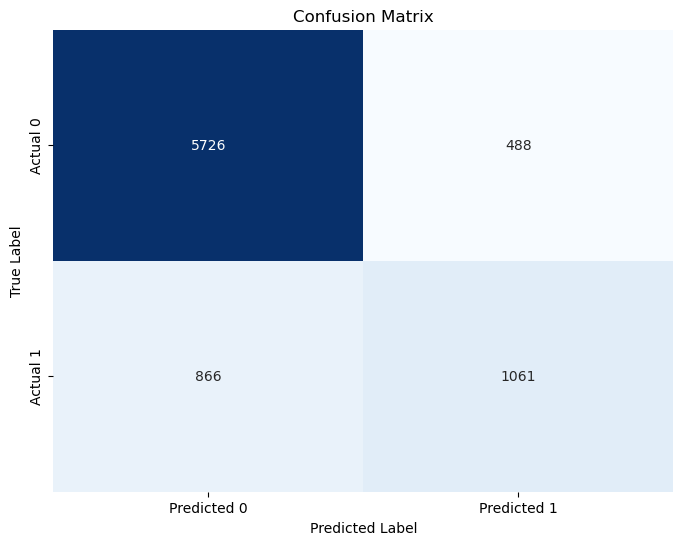

In [10]:
# Assuming X_test and y_test are already defined

# Use Logistic Regression for predictions
logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_train, y_train)
logistic_regression_predictions = logistic_regression_model.predict(X_test)

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, logistic_regression_predictions)

# Print accuracy score
accuracy = accuracy_score(y_test, logistic_regression_predictions)
print("Accuracy:", accuracy)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#tp, fp
#fn, tn

In [11]:
# Generate a classification report
classification_rep = classification_report(y_test, logistic_regression_predictions, target_names=['class 0', 'class 1'])
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

     class 0       0.87      0.92      0.89      6214
     class 1       0.68      0.55      0.61      1927

    accuracy                           0.83      8141
   macro avg       0.78      0.74      0.75      8141
weighted avg       0.83      0.83      0.83      8141



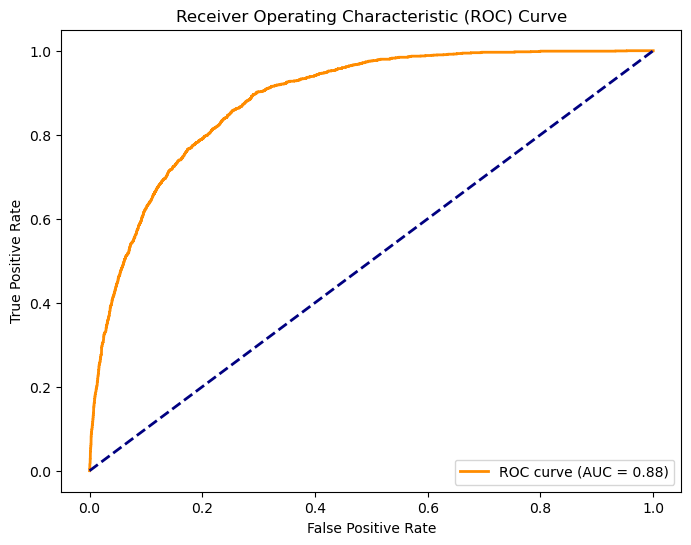

In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming logistic_regression_model is already trained, and X_test and y_test are defined

# Get predicted probabilities for the positive class (class 1)
logistic_regression_probabilities = logistic_regression_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, logistic_regression_probabilities)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Accuracy: 0.7801252917332023


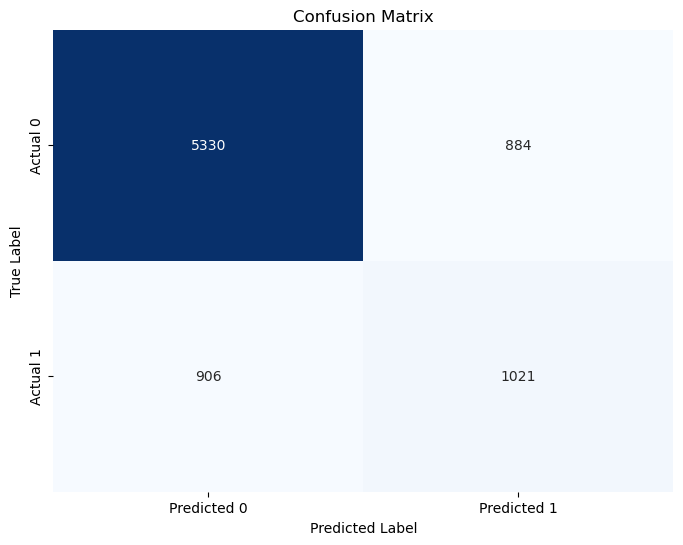

In [13]:
# Choose a different classification model (e.g., DecisionTreeClassifier)
classifier = DecisionTreeClassifier()

# Train the model
classifier.fit(X_train, y_train)

# Make predictions
predictions = classifier.predict(X_test)

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Print accuracy score
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()